In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import urllib as urllib
from tqdm import tqdm_notebook as tqdm
import gzip
from sklearn.linear_model import Ridge
import timeit

sys.path.append(os.path.abspath('..\\dataset'))
sys.path.append(os.path.abspath('..'))
import dataset as ds
from dataset.models.tf import VGG16, ResNet50, DenseNet121, Inception_v1
from dataset.opensets import MNIST
from dataset import B, V
PATH_TO_MNIST = os.path.join('..', 'datasets', 'MNIST')

In [2]:
mnist_set = MNIST(batch_class = ds.ImagesBatch)
image_sizes = [(size,size,1) for size in range(1, 102, 5)]
x = np.array([i[0] for i in image_sizes])

ExtractingExtractingExtractingExtracting    C:\Users\ROMANK~1\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\ROMANK~1\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\ROMANK~1\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\ROMANK~1\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz





In [3]:
def get_ppl(model, config, image_size):
    placeholders_config = {'images': {'shape':image_size,
                                     'name': 'resized_images'},
                           'labels': {'classes' : 10,
                                      'transform': 'ohe',
                                      'name': 'targets'}}
    
    config['inputs'] = placeholders_config
    config['loss'] = 'ce'
    config['input_block/inputs'] =  'images'
    config['output'] =  dict(ops=['labels', 'accuracy'],
                             data_format='channels_last')
    

    return (mnist_set.train.p
                         .init_variable('acc_history', init_on_each_run=list)
                         .init_model('dynamic', model, 'model', config=config)
                         .resize(shape=image_size[:2])
                         .train_model('model',
                                      fetches='accuracy',
                                      feed_dict={'images': B('images'),
                                                 'labels': B('labels')},
                                      save_to=V('acc_history'), mode='a'))


def measure_time_execution(func, n_experiments = 30):
    stat = []
    for _ in (range(n_experiments)):
        stat.append(timeit.timeit(func, number = 1))
    return np.mean(stat), np.std(stat)


def conduct_experiment(model, config, batch_size=64, n_experiments = 30):
    means = []
    stds = []

    for size in tqdm(image_sizes):
        ppl = get_ppl(model, config, size)
        get_batch = lambda x=0 : ppl.next_batch(batch_size=batch_size, shuffle=True, n_epochs=None)
        get_batch()
        mean, std = measure_time_execution(get_batch, n_experiments = n_experiments)
        means.append(mean)
        stds.append(std)
        
    return np.array(means), np.array(stds)


def fit_square(X, Y, k = 1, alpha = 1e-4):
    xaug = np.log(np.array(X).reshape(-1,1)[k:])
    linreg = Ridge(alpha).fit(xaug, np.log(Y[k:]-Y[0] ))
    b = linreg.coef_ 
    a = np.exp(linreg.intercept_)
    print('R squared = {:.2f}'.format(linreg.score(xaug, np.log(Y[k:]-Y[0] ))))
    print('a         = {:.1e}'.format(a))
    print('b         = {:.2f}'.format(b[0]))
    return a, b[0]


def fit_nlogn(X, Y, k = 1, alpha = 1e-4):
    xaug = np.log(np.array(X).reshape(-1,1)[k:])
    xaug = np.hstack((xaug, np.log(xaug)))
    linreg = Ridge(alpha).fit(xaug, np.log(Y[k:]-Y[0] ))
    b, c = linreg.coef_ 
    a = np.exp(linreg.intercept_)
    print('R squared = {:.2f}'.format(linreg.score(xaug, np.log(Y[k:]-Y[0] ))))
    print('a         = {:.1e}'.format(a))
    print('b         = {:.2f}'.format(b))
    print('c         = {:.2f}'.format(c))
    return a, b, c


def plot_results(x, means, stds, model_name, a, b, c = None):
    plt.figure(figsize=(16,9))
    plt.errorbar(x, means, yerr=2*stds, c='blue', label=model_name)
    plt.title('one batch (64) execution time in dependence of image size', fontsize=18)
    plt.xlabel('image size', fontsize=18)
    plt.ylabel('seconds', fontsize=18)

    xx = np.arange(min(x),max(x), 0.01)
    if not c:
        plt.plot(xx, (xx ** b) * a + means[0], label=r'$O(n^{2})$', c='red')
    else:
        plt.plot(xx, (xx ** b) * a * np.log(xx)**c+ means[0], label=r'$O(n^{b}log(x)^c)$', c='red')
    plt.legend(fontsize=18)


## VGG 16


### 500 nodes were used in two last fully connected layers


![kek](img/vgg16_table.jpg)

In [45]:
vgg_config = {'head/units' : [500,500,2]}
means_vgg, stds_vgg = conduct_experiment(model = VGG16, config = vgg_config, batch_size=64)

A Jupyter Widget

C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Text(0,0.5,'seconds')

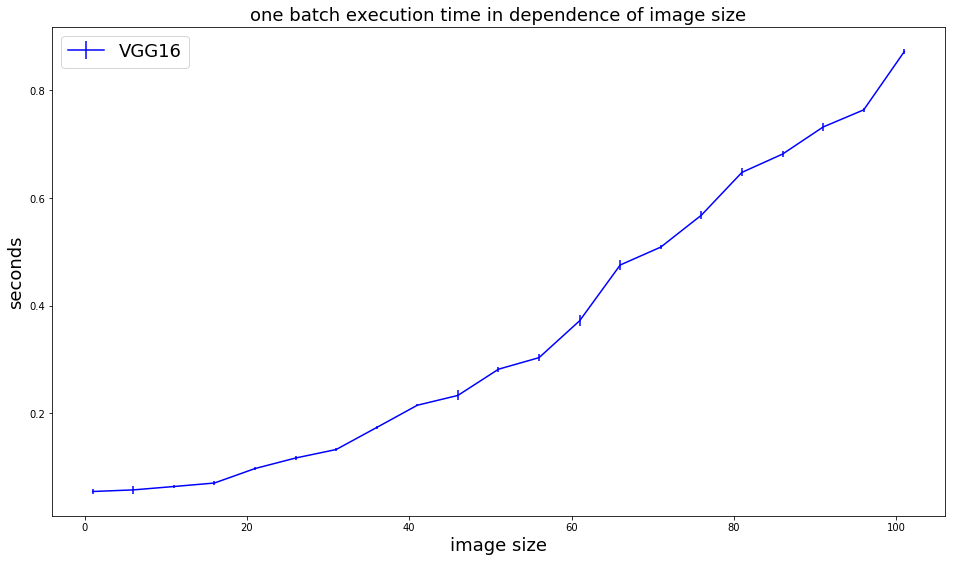

In [74]:
plt.figure(figsize=(16,9))
plt.errorbar(x, means_vgg, yerr=2*stds_vgg, c='blue', label = 'VGG16')
plt.title('one batch execution time in dependence of image size', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('image size', fontsize=18)
plt.ylabel('seconds', fontsize=18)

## looks like $O(n^2)$, let's check it

### It is assumed that $y = ax^b \Rightarrow \ln y = \ln a + b \ln x$

R squared = 1.00
a         = 7.6e-05
b         = 2.03


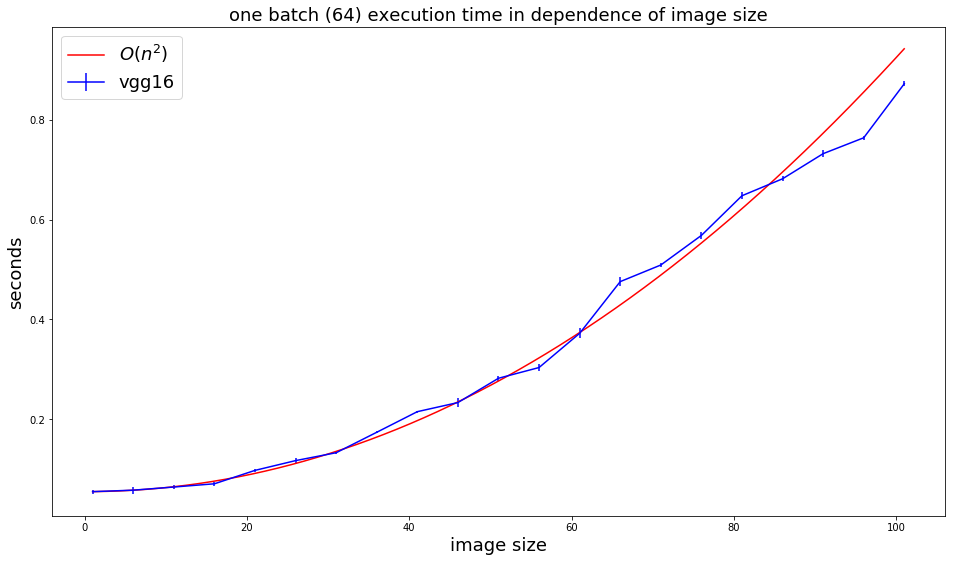

In [75]:
plot_results(x, means_vgg, stds_vgg, 'vgg16', *fit_square(x, means_vgg))

## Resnet50


## Base block:

![resnet_block](img/resnet_block.png)



## Architecture

![cheburek](img/resnet50.png)

In [48]:
resnet_config = {}
means_resnet, stds_resnet = conduct_experiment(model = ResNet50,
                                               config = resnet_config,
                                               batch_size=64)

A Jupyter Widget

C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


R squared = 0.99
a         = 2.7e-05
b         = 2.12


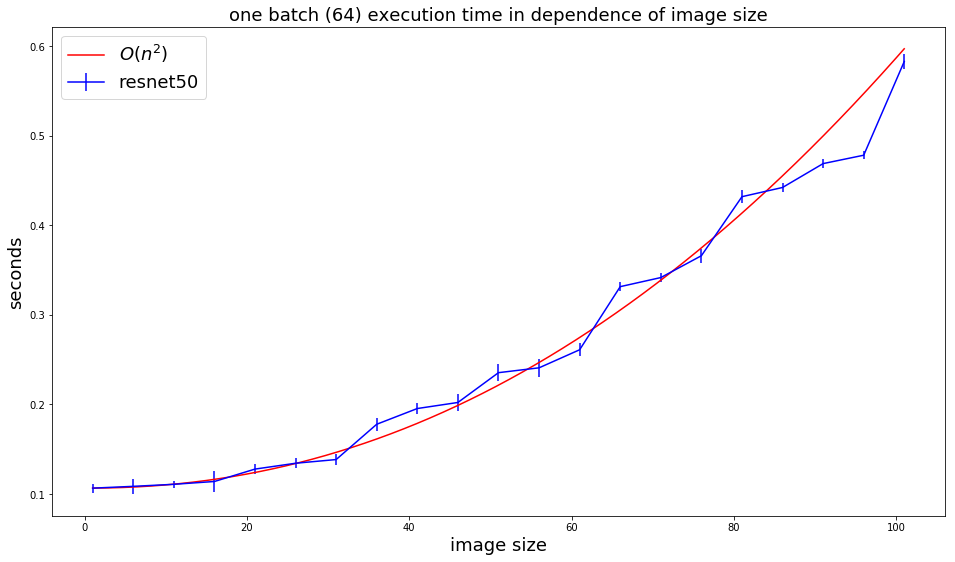

In [76]:
plot_results(x, means_resnet, stds_resnet, 'resnet50', *fit_square(x, means_resnet, 2, 1e-3))

## DenseNet169

Initialization of the model  takes too much time

![dense_block](img/dense_block.png)

## Architecture

![dense](img/densenet.png)

In [4]:
image_sizes = [(size,size,1) for size in range(1, 56, 5)]
x = np.array([i[0] for i in image_sizes])
means_densenet, stds_densenet = conduct_experiment(model = DenseNet121,
                                               config = {},
                                               batch_size=64)

A Jupyter Widget

R squared = 0.93
a         = 1.1e-04
b         = 1.93


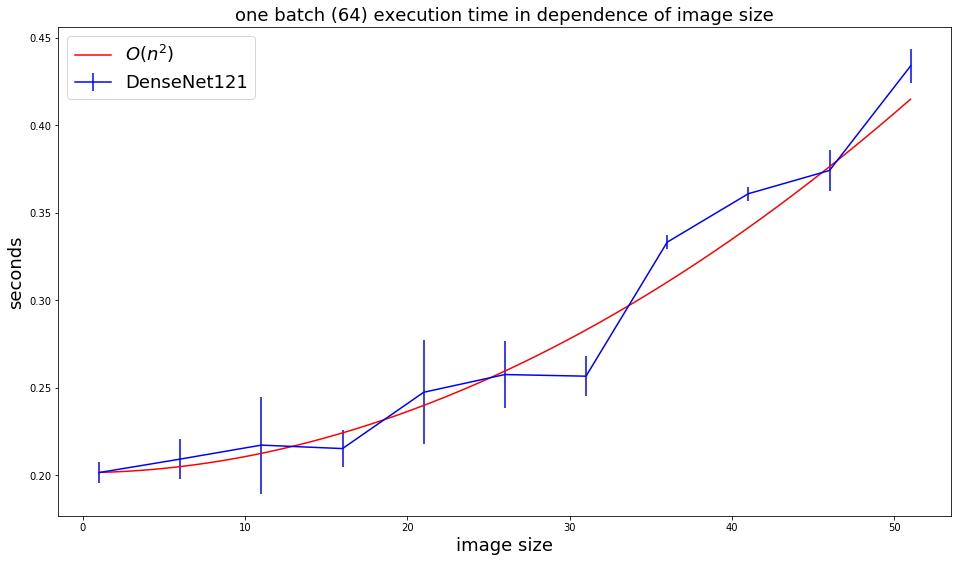

In [82]:
image_sizes = [(size,size,1) for size in range(1, 56, 5)]
x = np.array([i[0] for i in image_sizes])
plot_results(x, means_densenet, stds_densenet, 'DenseNet121', *fit_square(x, means_densenet, 2, 1e-3))

## Inception v1

![inception block](img/inception_block.png)

## Architecture
![googlelenet](img/googlenet.png)


In [13]:
image_sizes = [(size,size,1) for size in range(1, 102, 5)]
x = np.array([i[0] for i in image_sizes])
means_inception, stds_inception = conduct_experiment(model = Inception_v1,
                                               config = {},
                                               batch_size=64)

A Jupyter Widget

Exception ignored in: <generator object get_controller at 0x000002173D21F8E0>
Traceback (most recent call last):
  File "C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 4345, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects
Exception ignored in: <generator object get_controller at 0x000002173D21F570>
Traceback (most recent call last):
  File "C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 4345, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects


Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\Roman Khudorozhkov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Roman Khudorozhkov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

C:\Users\Roman Khudorozhkov\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


R squared = 0.99
a         = 3.8e-05
b         = 1.84


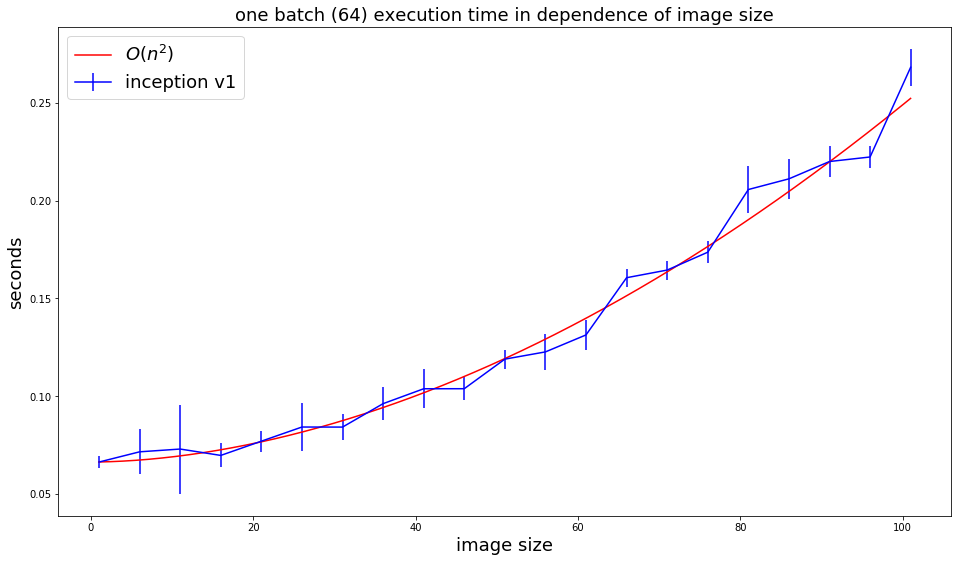

In [83]:
image_sizes = [(size,size,1) for size in range(1, 102, 5)]
x = np.array([i[0] for i in image_sizes])
a,b = fit_square(x, means_inception,4, 1e-4)
plot_results(x, means_inception, stds_inception, 'inception v1', a,b)

## all together

Text(0,0.5,'seconds')

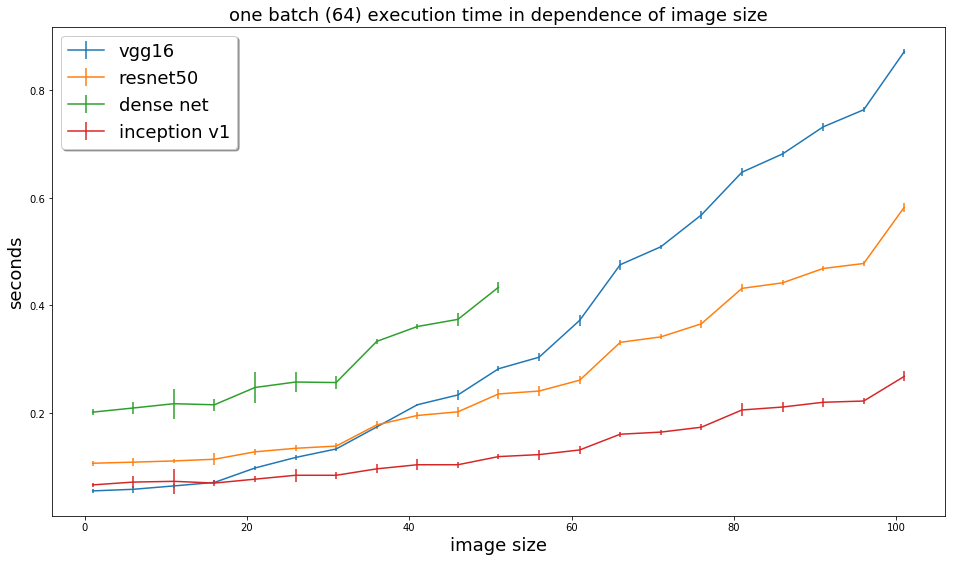

In [84]:
plt.figure(figsize=(16,9))
plt.errorbar(x, means_vgg, yerr=2*stds_vgg, label='vgg16')
plt.errorbar(x, means_resnet, yerr=2*stds_resnet, label='resnet50')
plt.errorbar(x[:11], means_densenet, yerr=2*stds_densenet, label='dense net')
plt.errorbar(x, means_inception, yerr=2*stds_inception, label='inception v1')
plt.title('one batch (64) execution time in dependence of image size', fontsize=18)
plt.legend(fontsize=18, frameon=True, shadow=True)
plt.xlabel('image size', fontsize=18)
plt.ylabel('seconds', fontsize=18)